In [ ]:
# !pip install --upgrade pandas

In [ ]:
# !pip install pyarrow

In [ ]:
#!pip install scikit-plot

In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 6.6MB 129kB/s eta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:


In [1]:
from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE

ImportError: No module named 'imblearn'

In [2]:
!pip list

Package                            Version    
---------------------------------- -----------
adal                               1.2.1      
alabaster                          0.7.9      
altair                             3.0.0      
anaconda-clean                     1.0        
anaconda-client                    1.5.1      
anaconda-navigator                 1.3.1      
argcomplete                        1.0.0      
arrow                              0.13.1     
asn1crypto                         0.24.0     
astroid                            1.4.7      
astropy                            1.2.1      
attrs                              19.1.0     
Automat                            0.7.0      
azure-common                       1.1.20     
azure-kusto-data                   0.0.11     
azure-kusto-ingest                 0.0.11     
azure-nspkg                        3.0.2      
azure-storage-blob                 1.5.0      
azure-storage-common               1.4.0      
azure-storage

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
#from numpy import nan as NA
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import scikitplot as skplt

from azure.storage.blob import BlockBlobService
import pyarrow.parquet as pq
from io import StringIO
from io import BytesIO

%matplotlib inline

In [3]:
#Azure account credentials
azure_storage_account_name = "agedatasciencecocstorage"
azure_storage_account_key = "V/FXG+lIWtYc854wbRA8BxGCLGJijS0NDwLvNHfmAxqRopAL3WHWGIQoHxpArG9lZoX+iY+dvtPYoB379w4MIw=="

if azure_storage_account_name is None or azure_storage_account_key is None:
    raise Exception("You must provide a name and key for an Azure Storage account")

In [4]:
# First, we need to connect to our blob via the BlobService
blob_service = BlockBlobService(azure_storage_account_name, azure_storage_account_key)
# There are also methods to list containers and blobs
#containers = blob_service.list_containers()
blobs = blob_service.list_blobs('banking-dm')

In [ ]:
# # List the blobs in the container.
# print("\nList blobs in the container")
# #generator = block_blob_service.list_blobs(container_name)
# for blob in blobs:
#     print("\t Blob name: " + blob.name)

### Read Data

In [5]:
container_name = "banking-dm"

In [121]:
blob_name_parquet = 'ailiev/3M_AVG_MCIF_2018-01__2018-03.parquet.gzip' 
byte_stream = BytesIO()
try:
    blob_service.get_blob_to_stream(container_name=container_name, blob_name=blob_name_parquet, stream=byte_stream)
    df = pq.read_table(source=byte_stream).to_pandas()
    # Do work on df ...
finally:
    # Add finally block to ensure closure of the stream
    byte_stream.close()

In [7]:
df.shape

(100215, 278)

In [8]:
df.head()

,Customer_ID,AGE_MONTHS,SECTOR,CUSTOMER_ECO_BRANCH,MARITAL_STATUS,GENDER,CUSTOMER_CATEGORY,CUSTOMER_TYPE,AT_LEAST_ONE_ACTIVE,AVG_DEPOSITS_minus_LOANS,...,TOTAL_SAVING_BAL,TOTAL_SAVING_CNT,TOTAL_TNAM,CLOSED_MONTHS_MIN,DC_MATURE_MONTHS_MAX,MATURE_MONTHS_MAX,MATURE_MONTHS_MIN,MONTHS_TILL_EXP_MAX,MONTHS_TILL_EXP_MIN,AVG_PERIOD
0,1,558,Arts and Communications,BR160,Divorced,F,None,Individual,0.666667,157.725083,...,37.805250,1.0,1026.335000,-1,-1,54,0,-1,-1,2018-01--2018-03
1,2,519,Finance,BR09,Married,M,None,Professional,1.000000,0.000000,...,0.000000,1.0,161.413333,-1,59,215,213,-1,-1,2018-01--2018-03
2,3,310,Manufacturing,BR145,Married,M,None,Individual,1.000000,1616.158533,...,1616.158533,1.0,3606.596667,-1,-1,229,227,-1,-1,2018-01--2018-03
3,4,484,Health and Science,BR14,None,None,Retail,Small Business,1.000000,-271.317717,...,208.618900,1.0,3869.115000,-1,93,120,0,17,-18,2018-01--2018-03
4,5,477,Agriculture and Food,BR171,Single,M,None,Individual,1.000000,-836.073333,...,0.000000,1.0,1923.821667,-1,-1,171,68,2,-1,2018-01--2018-03


In [ ]:
# pd.value_counts(df['CUSTOMER_TYPE'])

In [122]:
#remove SBBs
df = df[df['CUSTOMER_TYPE']=="Individual"]

In [123]:
df.shape

(84302, 278)

In [124]:
blob_name_parquet_label = 'ailiev/MG_Offer_5.parquet.gzip'
byte_stream = BytesIO()
try:
    blob_service.get_blob_to_stream(container_name=container_name, blob_name=blob_name_parquet_label, stream=byte_stream)
    label = pq.read_table(source=byte_stream).to_pandas()
    # Do work on df ...
finally:
    # Add finally block to ensure closure of the stream
    byte_stream.close()

In [125]:
label.shape

(84302, 2)

In [14]:
#label.head()

In [126]:
df = df.merge(label, on="Customer_ID")

In [127]:
df.shape

(84302, 279)

### Analysis

In [128]:
del df['AVG_PERIOD']

In [129]:
demographic_columns = ['Customer_ID', 'CUSTOMER_TYPE', 'CUSTOMER_CATEGORY', 'GENDER', 'MARITAL_STATUS', 'CUSTOMER_ECO_BRANCH', 'SECTOR', 'AGE_MONTHS', 
                      'MG_OFFER']

In [130]:
indep_columns = [col for col in df.columns if col not in demographic_columns]

In [131]:
len(indep_columns)

269

In [132]:
#replaces inf with nan
df.replace( -np.inf, np.nan, inplace=True)
#fill nan with 0
df.fillna(0, inplace=True)

In [133]:
# Create independent and target sets
independents = df[indep_columns].values
target = df['MG_OFFER'].values

In [134]:
X_train, X_test, y_train, y_test = train_test_split(independents, target, test_size=0.3, random_state=0)

### Decision Tree

In [155]:
#tree set up
tree = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_leaf=200)

In [156]:
#train tree
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [157]:
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.904
Accuracy on test set: 0.908


In [158]:
pred_tree = tree.predict(X_test)

In [159]:
print(metrics.classification_report(y_test, pred_tree,target_names=["False", "True"]))

             precision    recall  f1-score   support

      False       0.91      1.00      0.95     22974
       True       0.00      0.00      0.00      2317

avg / total       0.83      0.91      0.86     25291



/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [152]:
confusion = metrics.confusion_matrix(y_test, pred_tree)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[22974     0]
 [ 2317     0]]


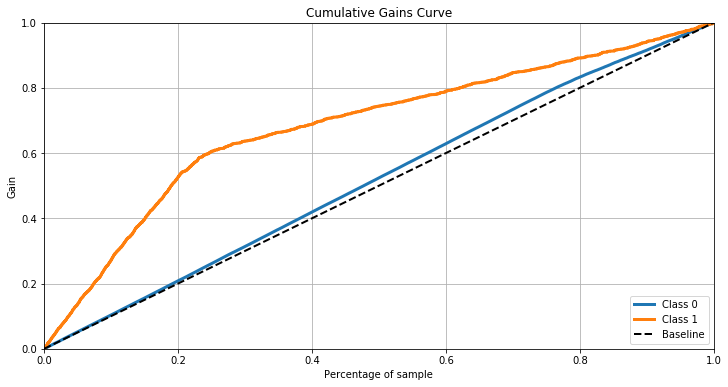

In [153]:
predicted_probas = tree.predict_proba(X_test)
plt.rcParams["figure.figsize"] = (12,6)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

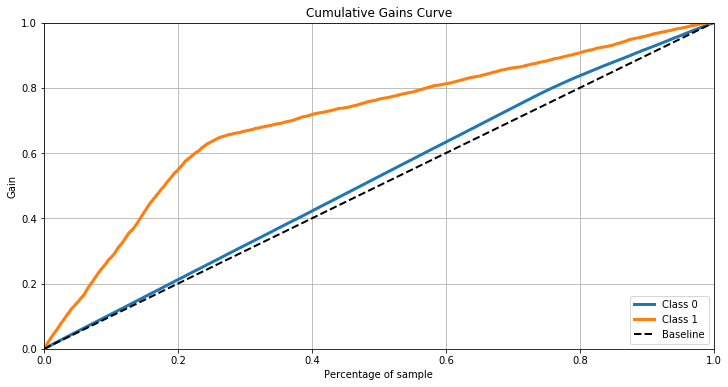

In [154]:
predicted_probas_train = tree.predict_proba(X_train)
skplt.metrics.plot_cumulative_gain(y_train, predicted_probas_train)
plt.show()

In [143]:
#tree feature importance
features = pd.DataFrame(tree.feature_importances_, columns=['Value'], index=indep_columns)
features.sort_values('Value', ascending=False, inplace=True)

In [96]:
def plot_feature_importances(model, top_n):
    model = model.head(top_n)
    n_features = model.shape[0]
    plt.barh(range(n_features), model['Value'], align='center')
    plt.yticks(np.arange(n_features), model.index)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

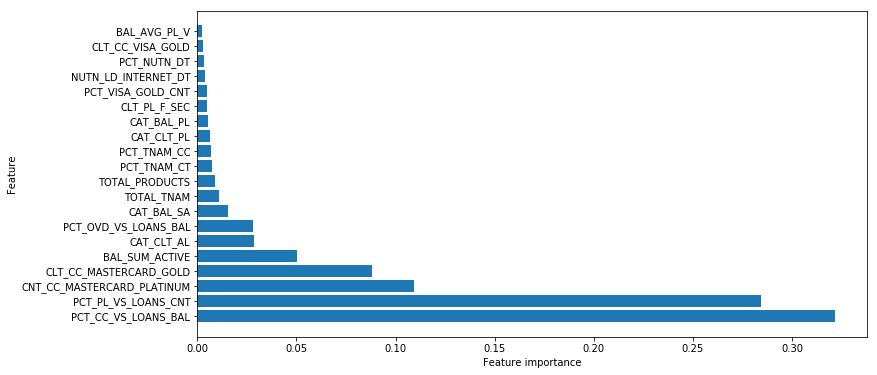

In [144]:
plot_feature_importances(features, 20)

In [145]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["True", "False"],
feature_names=indep_columns, impurity=False, filled=True)

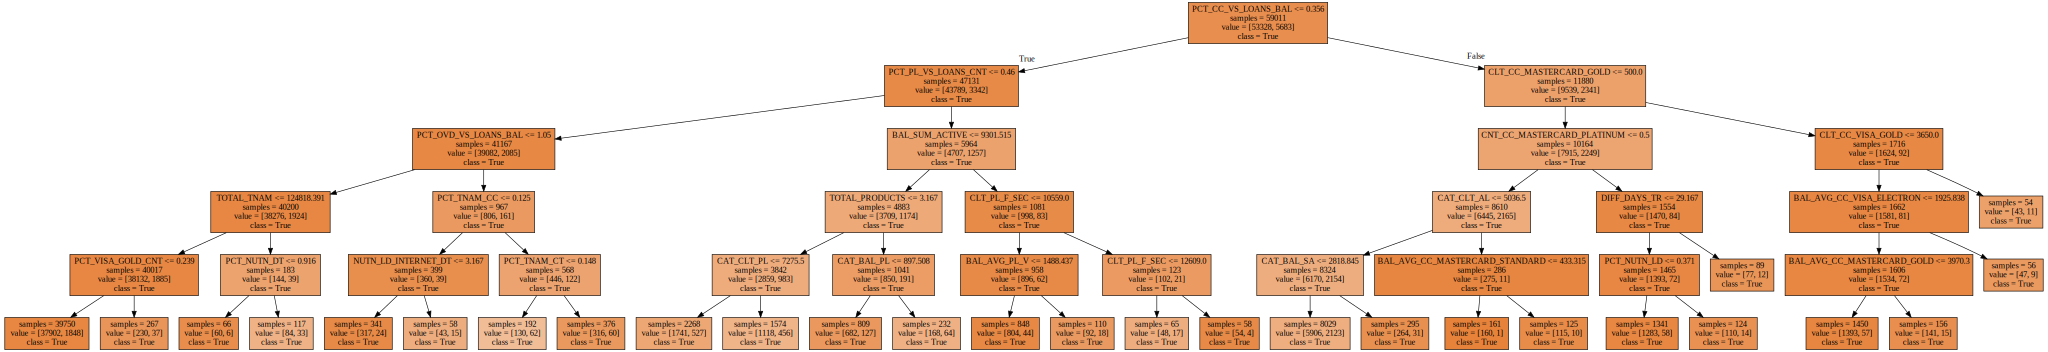

In [146]:
#visualise tree
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)